In [82]:
# %pip install torch torch_geometric pytorch_lightning wandb scikit-learn matplotlib

In [83]:
import torch
from torch_geometric.data import Data
import pandas as pd
import wandb
from sklearn.preprocessing import MultiLabelBinarizer
import ast
import numpy as np

pd.set_option('display.max_columns', None)

# Load the data

In [84]:
df = pd.read_csv('../get_lineup_target_score/nba_with_lineup_score.csv')
pre_df = pd.read_csv('../pre_season/pre_lineup_vs_lineup.csv')

In [85]:
pre_df.fillna(0, inplace=True)

In [86]:
df.dropna(subset=['net_score'], inplace=True)
df = df[~df['net_score'].isin([np.inf, -np.inf])]

In [87]:
df.size

91200

In [88]:
all_lineups = pd.concat([df['home_lineup'], df['away_lineup']]).unique()
pre_df_lineups = pd.concat([pre_df['home_lineup'], pre_df['away_lineup']]).unique()
filtered_lineups = [lineup for lineup in all_lineups if lineup in pre_df_lineups]
all_lineups = np.array(filtered_lineups)

In [89]:
df = df[df['home_lineup'].isin(all_lineups) & df['away_lineup'].isin(all_lineups)]
pre_df = pre_df[pre_df['home_lineup'].isin(all_lineups) & pre_df['away_lineup'].isin(all_lineups)]

In [90]:
lineups_df = pd.DataFrame(all_lineups, columns=['lineup'])
lineups_df["3pt_made"] = 0
lineups_df["points"] = 0
lineups_df["assists"] = 0
lineups_df["def_rebounds"] = 0
lineups_df["off_rebounds"] = 0
lineups_df["fouls"] = 0
lineups_df["2pt_made"] = 0
lineups_df["turnovers"] = 0
lineups_df["ft_made"] = 0
lineups_df["steals"] = 0
lineups_df["blocks"] = 0

In [91]:
cols = ['3pt_made', 'points', 'assists', 'def_rebounds', 'off_rebounds', 'fouls', '2pt_made', 'turnovers', 'ft_made', 'steals', 'blocks']
for index, row in pre_df.iterrows():
    home_lineup = row['home_lineup']
    away_lineup = row['away_lineup']
    
    for col in cols:
        home_col = 'home_' + col
        away_col = 'away_' + col
        if home_col in row and away_col in row:
            lineups_df.loc[lineups_df['lineup'] == home_lineup, col] += row[home_col]
            lineups_df.loc[lineups_df['lineup'] == away_lineup, col] += row[away_col]
        else:
            print(f'Column {home_col} or {away_col} not found in row')

In [92]:
def create_lineup_graph(df, pre_df):
    all_lineups = pd.concat([df['home_lineup'], df['away_lineup']]).unique()
    pre_df_lineups = pd.concat([pre_df['home_lineup'], pre_df['away_lineup']]).unique()
    filtered_lineups = [lineup for lineup in all_lineups if lineup in pre_df_lineups]
    all_lineups = np.array(filtered_lineups)

    df = df[df['home_lineup'].isin(all_lineups) & df['away_lineup'].isin(all_lineups)]
    pre_df = pre_df[pre_df['home_lineup'].isin(all_lineups) & pre_df['away_lineup'].isin(all_lineups)]

    lineups_df = pd.DataFrame(all_lineups, columns=['lineup'])
    lineups_df["3pt_made"] = 0
    lineups_df["points"] = 0
    lineups_df["assists"] = 0
    lineups_df["def_rebounds"] = 0
    lineups_df["off_rebounds"] = 0
    lineups_df["fouls"] = 0
    lineups_df["2pt_made"] = 0
    lineups_df["turnovers"] = 0
    lineups_df["ft_made"] = 0
    lineups_df["steals"] = 0
    lineups_df["blocks"] = 0

    cols = ['3pt_made', 'points', 'assists', 'def_rebounds', 'off_rebounds', 'fouls', '2pt_made', 'turnovers', 'ft_made', 'steals', 'blocks']
    for index, row in pre_df.iterrows():
        home_lineup = row['home_lineup']
        away_lineup = row['away_lineup']
        
        for col in cols:
            home_col = 'home_' + col
            away_col = 'away_' + col
            if home_col in row and away_col in row:
                lineups_df.loc[lineups_df['lineup'] == home_lineup, col] += row[home_col]
                lineups_df.loc[lineups_df['lineup'] == away_lineup, col] += row[away_col]
            else:
                print(f'Column {home_col} or {away_col} not found in row')
    
    # Create unique lineup nodes
    lineup2idx = {lineup: idx for idx, lineup in enumerate(lineups_df['lineup'])}
    
    # Create node features based on lineups_df
    x = torch.tensor(lineups_df.iloc[:, 1:].values, dtype=torch.float)
    
    # Create directed edges with score-based direction
    edge_index = []
    edge_attr = []
    
    for _, row in df.iterrows():
        home = row['home_lineup']
        away = row['away_lineup']
        home_idx = lineup2idx[home]
        away_idx = lineup2idx[away]
        
        # Determine edge direction based on normalized scores
        if row['normalized_home_score'] > row['normalized_away_score']:
            src, dst = home_idx, away_idx
        else:
            src, dst = away_idx, home_idx
            
        edge_index.append([src, dst])
        edge_attr.append(abs(row['net_score']))
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1)
    
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        num_nodes=len(lineups_df))

In [93]:
data = create_lineup_graph(df, pre_df)

In [94]:
data

Data(x=[678, 11], edge_index=[2, 781], edge_attr=[781, 1], num_nodes=678)

# GNN Model

In [95]:
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GINEConv
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy, AUROC

In [ ]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, num_layers, hidden_dim, dropout_rate):
        super().__init__()
        self.convs = nn.ModuleList()
        self.dropout_rate = dropout_rate
        for _ in range(num_layers):
            conv = GINEConv(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, hidden_dim),
                ),
                train_eps=True,
                edge_dim=1,
            )
            self.convs.append(conv)
            input_dim = hidden_dim
    
    def forward(self, x, edge_index, edge_attr):
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
        return x

# Link Prediction Decoder with Edge Attributes
class LinkPredictor(nn.Module):
    def __init__(self, num_layers, hidden_dim):
        super().__init__()
        mlp_layers = []
        current_dim = 2 * hidden_dim
        for _ in range(num_layers):
            mlp_layers.append(nn.Linear(current_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            current_dim = hidden_dim
        mlp_layers.append(nn.Linear(hidden_dim, 1))
        mlp_layers.append(nn.Sigmoid())
        self.mlp = nn.Sequential(*mlp_layers)
    
    def forward(self, u_emb, v_emb):
        concatenated = torch.cat([u_emb, v_emb], dim=1)
        return self.mlp(concatenated).squeeze()

# Lightning Module for Training
class LitGNN(pl.LightningModule):
    def __init__(self,
                input_dim,
                # Conv layer parameters
                conv_layers=2,
                conv_hidden_dim=64,
                # Link prediction parameters
                link_predictor_layers=1,
                link_hidden_dim=64,
                # Training parameters
                learning_rate=0.001,
                weight_decay=0.0001,
                dropout_rate=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.gnn = GNNModel(input_dim, conv_layers, conv_hidden_dim, dropout_rate)
        self.link_predictor = LinkPredictor(link_predictor_layers, link_hidden_dim)
        self.loss_fn = nn.BCELoss()

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # Initialize metrics
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')
        self.train_auroc = AUROC(task='binary')
        self.val_auroc = AUROC(task='binary')
        self.test_auroc = AUROC(task='binary')
    
    def forward(self, x, edge_index, edge_attr):
        return self.gnn(x, edge_index, edge_attr)
    
    def training_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('train_loss', loss, prog_bar=True)
        # print(f"Train Loss: {loss:.4f}")

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.train_acc(preds_binary, edge_label.int())
        self.log('train_acc', acc, prog_bar=True)
        # print(f"Train Accuracy: {acc:.4f}")

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:
            auc = self.train_auroc(preds, edge_label.int())
            self.log('train_auc', auc, prog_bar=True)
            # print(f"Train AUC: {auc:.4f}")

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('val_loss', loss, prog_bar=True)

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.val_acc(preds_binary, edge_label.int())
        self.log('val_acc', acc, prog_bar=True)

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:  # Ensure both classes are present
            auc = self.val_auroc(preds, edge_label.int())
            self.log('val_auc', auc, prog_bar=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('test_loss', loss, prog_bar=True)

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.test_acc(preds_binary, edge_label.int())
        self.log('test_acc', acc, prog_bar=True)

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:
            auc = self.test_auroc(preds, edge_label.int())
            self.log('test_auc', auc, prog_bar=True)

        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )

In [107]:
# Function to add reversed edges as negatives to a Data object
def add_reversed_negatives(data):
    if data.edge_index.size(1) == 0:
        return data  # Skip if no edges
    original_edges = data.edge_index
    reversed_edges = torch.flip(original_edges, dims=[0])
    
    # Combine original and reversed edges
    edge_label_index = torch.cat([original_edges, reversed_edges], dim=1)
    edge_label = torch.cat([
        torch.ones(original_edges.size(1)),
        torch.zeros(reversed_edges.size(1))
    ])
    
    # Use original edge_attr for both directions
    edge_label_attr = torch.cat([data.edge_attr, data.edge_attr], dim=0)
    
    # Shuffle the combined data
    perm = torch.randperm(edge_label_index.size(1))
    edge_label_index = edge_label_index[:, perm]
    edge_label_attr = edge_label_attr[perm]
    edge_label = edge_label[perm]
    
    data.edge_label_index = edge_label_index
    data.edge_label_attr = edge_label_attr
    data.edge_label = edge_label
    return data

In [108]:
batch_size = 1
train_data, val_data, test_data = RandomLinkSplit(num_val=0.1, num_test=0.1)(data)
train_data = add_reversed_negatives(train_data)
val_data = add_reversed_negatives(val_data)
test_data = add_reversed_negatives(test_data)
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

In [113]:
model = LitGNN(input_dim=data.x.shape[1])

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | train
----------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.7192
Train Accuracy: 0.4936
Train AUC: 0.4833
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s, v_num=71, train_loss=0.719, train_acc=0.494, train_auc=0.483, val_loss=0.688, val_acc=0.552, val_auc=0.645]

Metric val_loss improved. New best score: 0.688


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.719, train_acc=0.494, train_auc=0.483, val_loss=0.688, val_acc=0.552, val_auc=0.645]        Train Loss: 0.7112
Train Accuracy: 0.5256
Train AUC: 0.5276
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s, v_num=71, train_loss=0.711, train_acc=0.526, train_auc=0.528, val_loss=0.680, val_acc=0.602, val_auc=0.710]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.680


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.711, train_acc=0.526, train_auc=0.528, val_loss=0.680, val_acc=0.602, val_auc=0.710]        Train Loss: 0.6903
Train Accuracy: 0.5888
Train AUC: 0.6226
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s, v_num=71, train_loss=0.690, train_acc=0.589, train_auc=0.623, val_loss=0.674, val_acc=0.623, val_auc=0.726]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.674


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.690, train_acc=0.589, train_auc=0.623, val_loss=0.674, val_acc=0.623, val_auc=0.726]        Train Loss: 0.6781
Train Accuracy: 0.6272
Train AUC: 0.6585
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s, v_num=71, train_loss=0.678, train_acc=0.627, train_auc=0.658, val_loss=0.670, val_acc=0.642, val_auc=0.729]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.670


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.678, train_acc=0.627, train_auc=0.658, val_loss=0.670, val_acc=0.642, val_auc=0.729]        Train Loss: 0.7009
Train Accuracy: 0.6616
Train AUC: 0.6723
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s, v_num=71, train_loss=0.701, train_acc=0.662, train_auc=0.672, val_loss=0.669, val_acc=0.649, val_auc=0.731]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.669


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.701, train_acc=0.662, train_auc=0.672, val_loss=0.669, val_acc=0.649, val_auc=0.731]        Train Loss: 0.6740
Train Accuracy: 0.6544
Train AUC: 0.7040
Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.674, train_acc=0.654, train_auc=0.704, val_loss=0.669, val_acc=0.642, val_auc=0.737]        Train Loss: 0.6755
Train Accuracy: 0.6664
Train AUC: 0.7034
Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.675, train_acc=0.666, train_auc=0.703, val_loss=0.670, val_acc=0.650, val_auc=0.737]        Train Loss: 0.6750
Train Accuracy: 0.6688
Train AUC: 0.7253
Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.675, train_acc=0.669, train_auc=0.725, val_loss=0.669, val_acc=0.662, val_auc=0.740]        Train Loss: 0.6822
Train Accuracy: 0.6584
Train AUC: 0.7239
Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s, v_num=71, train_loss=0.682, train_acc=0.658, train_auc=0.

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.667


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.682, train_acc=0.658, train_auc=0.724, val_loss=0.667, val_acc=0.677, val_auc=0.742]        Train Loss: 0.7125
Train Accuracy: 0.6944
Train AUC: 0.7013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=71, train_loss=0.713, train_acc=0.694, train_auc=0.701, val_loss=0.665, val_acc=0.688, val_auc=0.743]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.665


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.713, train_acc=0.694, train_auc=0.701, val_loss=0.665, val_acc=0.688, val_auc=0.743]       Train Loss: 0.6561
Train Accuracy: 0.6848
Train AUC: 0.7322
Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s, v_num=71, train_loss=0.656, train_acc=0.685, train_auc=0.732, val_loss=0.663, val_acc=0.704, val_auc=0.745]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.663


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.656, train_acc=0.685, train_auc=0.732, val_loss=0.663, val_acc=0.704, val_auc=0.745]        Train Loss: 0.6816
Train Accuracy: 0.7208
Train AUC: 0.7294
Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 21.04it/s, v_num=71, train_loss=0.682, train_acc=0.721, train_auc=0.729, val_loss=0.661, val_acc=0.713, val_auc=0.746]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.661


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.682, train_acc=0.721, train_auc=0.729, val_loss=0.661, val_acc=0.713, val_auc=0.746]        Train Loss: 0.6815
Train Accuracy: 0.7224
Train AUC: 0.7293
Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=71, train_loss=0.682, train_acc=0.722, train_auc=0.729, val_loss=0.659, val_acc=0.734, val_auc=0.748]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.659


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.682, train_acc=0.722, train_auc=0.729, val_loss=0.659, val_acc=0.734, val_auc=0.748]        Train Loss: 0.6714
Train Accuracy: 0.7240
Train AUC: 0.7378
Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s, v_num=71, train_loss=0.671, train_acc=0.724, train_auc=0.738, val_loss=0.658, val_acc=0.747, val_auc=0.749]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.658


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.671, train_acc=0.724, train_auc=0.738, val_loss=0.658, val_acc=0.747, val_auc=0.749]        Train Loss: 0.6799
Train Accuracy: 0.7304
Train AUC: 0.7365
Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s, v_num=71, train_loss=0.680, train_acc=0.730, train_auc=0.737, val_loss=0.657, val_acc=0.745, val_auc=0.750]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.657


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.680, train_acc=0.730, train_auc=0.737, val_loss=0.657, val_acc=0.745, val_auc=0.750]        Train Loss: 0.6563
Train Accuracy: 0.7296
Train AUC: 0.7467
Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s, v_num=71, train_loss=0.656, train_acc=0.730, train_auc=0.747, val_loss=0.656, val_acc=0.743, val_auc=0.751]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.656


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.656, train_acc=0.730, train_auc=0.747, val_loss=0.656, val_acc=0.743, val_auc=0.751]        Train Loss: 0.6610
Train Accuracy: 0.7184
Train AUC: 0.7255
Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=71, train_loss=0.661, train_acc=0.718, train_auc=0.726, val_loss=0.654, val_acc=0.742, val_auc=0.753]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.654


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.661, train_acc=0.718, train_auc=0.726, val_loss=0.654, val_acc=0.742, val_auc=0.753]        Train Loss: 0.6592
Train Accuracy: 0.7248
Train AUC: 0.7185
Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s, v_num=71, train_loss=0.659, train_acc=0.725, train_auc=0.719, val_loss=0.653, val_acc=0.741, val_auc=0.755]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.653


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.659, train_acc=0.725, train_auc=0.719, val_loss=0.653, val_acc=0.741, val_auc=0.755]        Train Loss: 0.6607
Train Accuracy: 0.7320
Train AUC: 0.7234
Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, v_num=71, train_loss=0.661, train_acc=0.732, train_auc=0.723, val_loss=0.651, val_acc=0.742, val_auc=0.756]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.651


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.661, train_acc=0.732, train_auc=0.723, val_loss=0.651, val_acc=0.742, val_auc=0.756]        Train Loss: 0.6581
Train Accuracy: 0.7264
Train AUC: 0.7422
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s, v_num=71, train_loss=0.658, train_acc=0.726, train_auc=0.742, val_loss=0.649, val_acc=0.741, val_auc=0.758]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.649


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.658, train_acc=0.726, train_auc=0.742, val_loss=0.649, val_acc=0.741, val_auc=0.758]        Train Loss: 0.6496
Train Accuracy: 0.7568
Train AUC: 0.7532
Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s, v_num=71, train_loss=0.650, train_acc=0.757, train_auc=0.753, val_loss=0.647, val_acc=0.742, val_auc=0.759]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.647


Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.650, train_acc=0.757, train_auc=0.753, val_loss=0.647, val_acc=0.742, val_auc=0.759]        Train Loss: 0.6432
Train Accuracy: 0.7472
Train AUC: 0.7635
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s, v_num=71, train_loss=0.643, train_acc=0.747, train_auc=0.764, val_loss=0.644, val_acc=0.741, val_auc=0.759]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.644


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.643, train_acc=0.747, train_auc=0.764, val_loss=0.644, val_acc=0.741, val_auc=0.759]        Train Loss: 0.6635
Train Accuracy: 0.7360
Train AUC: 0.7326
Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s, v_num=71, train_loss=0.664, train_acc=0.736, train_auc=0.733, val_loss=0.642, val_acc=0.741, val_auc=0.760]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.642


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.664, train_acc=0.736, train_auc=0.733, val_loss=0.642, val_acc=0.741, val_auc=0.760]        Train Loss: 0.6585
Train Accuracy: 0.7456
Train AUC: 0.7554
Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, v_num=71, train_loss=0.659, train_acc=0.746, train_auc=0.755, val_loss=0.639, val_acc=0.745, val_auc=0.762]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.639


Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.659, train_acc=0.746, train_auc=0.755, val_loss=0.639, val_acc=0.745, val_auc=0.762]        Train Loss: 0.6555
Train Accuracy: 0.7352
Train AUC: 0.7501
Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s, v_num=71, train_loss=0.655, train_acc=0.735, train_auc=0.750, val_loss=0.637, val_acc=0.744, val_auc=0.764]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.637


Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.655, train_acc=0.735, train_auc=0.750, val_loss=0.637, val_acc=0.744, val_auc=0.764]        Train Loss: 0.6293
Train Accuracy: 0.7440
Train AUC: 0.7534
Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s, v_num=71, train_loss=0.629, train_acc=0.744, train_auc=0.753, val_loss=0.634, val_acc=0.744, val_auc=0.766]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.634


Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.629, train_acc=0.744, train_auc=0.753, val_loss=0.634, val_acc=0.744, val_auc=0.766]        Train Loss: 0.6405
Train Accuracy: 0.7408
Train AUC: 0.7453
Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s, v_num=71, train_loss=0.640, train_acc=0.741, train_auc=0.745, val_loss=0.631, val_acc=0.746, val_auc=0.767]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.631


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.640, train_acc=0.741, train_auc=0.745, val_loss=0.631, val_acc=0.746, val_auc=0.767]        Train Loss: 0.6314
Train Accuracy: 0.7448
Train AUC: 0.7641
Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=71, train_loss=0.631, train_acc=0.745, train_auc=0.764, val_loss=0.627, val_acc=0.744, val_auc=0.768]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.627


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.631, train_acc=0.745, train_auc=0.764, val_loss=0.627, val_acc=0.744, val_auc=0.768]        Train Loss: 0.6403
Train Accuracy: 0.7312
Train AUC: 0.7484
Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s, v_num=71, train_loss=0.640, train_acc=0.731, train_auc=0.748, val_loss=0.623, val_acc=0.742, val_auc=0.770]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.623


Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.640, train_acc=0.731, train_auc=0.748, val_loss=0.623, val_acc=0.742, val_auc=0.770]        Train Loss: 0.6465
Train Accuracy: 0.7352
Train AUC: 0.7476
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s, v_num=71, train_loss=0.647, train_acc=0.735, train_auc=0.748, val_loss=0.620, val_acc=0.740, val_auc=0.772]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.620


Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.647, train_acc=0.735, train_auc=0.748, val_loss=0.620, val_acc=0.740, val_auc=0.772]        Train Loss: 0.6487
Train Accuracy: 0.7472
Train AUC: 0.7611
Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s, v_num=71, train_loss=0.649, train_acc=0.747, train_auc=0.761, val_loss=0.617, val_acc=0.742, val_auc=0.774]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.617


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.649, train_acc=0.747, train_auc=0.761, val_loss=0.617, val_acc=0.742, val_auc=0.774]        Train Loss: 0.6454
Train Accuracy: 0.7304
Train AUC: 0.7445
Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s, v_num=71, train_loss=0.645, train_acc=0.730, train_auc=0.744, val_loss=0.615, val_acc=0.746, val_auc=0.777]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.615


Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.645, train_acc=0.730, train_auc=0.744, val_loss=0.615, val_acc=0.746, val_auc=0.777]        Train Loss: 0.6347
Train Accuracy: 0.7384
Train AUC: 0.7524
Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s, v_num=71, train_loss=0.635, train_acc=0.738, train_auc=0.752, val_loss=0.614, val_acc=0.739, val_auc=0.780]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.614


Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.635, train_acc=0.738, train_auc=0.752, val_loss=0.614, val_acc=0.739, val_auc=0.780]        Train Loss: 0.6380
Train Accuracy: 0.7240
Train AUC: 0.7441
Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s, v_num=71, train_loss=0.638, train_acc=0.724, train_auc=0.744, val_loss=0.614, val_acc=0.735, val_auc=0.784]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.614


Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.638, train_acc=0.724, train_auc=0.744, val_loss=0.614, val_acc=0.735, val_auc=0.784]        Train Loss: 0.6216
Train Accuracy: 0.7416
Train AUC: 0.7673
Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s, v_num=71, train_loss=0.622, train_acc=0.742, train_auc=0.767, val_loss=0.612, val_acc=0.735, val_auc=0.788]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.612


Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.622, train_acc=0.742, train_auc=0.767, val_loss=0.612, val_acc=0.735, val_auc=0.788]        Train Loss: 0.6222
Train Accuracy: 0.7424
Train AUC: 0.7741
Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, v_num=71, train_loss=0.622, train_acc=0.742, train_auc=0.774, val_loss=0.609, val_acc=0.730, val_auc=0.791]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.609


Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.622, train_acc=0.742, train_auc=0.774, val_loss=0.609, val_acc=0.730, val_auc=0.791]        Train Loss: 0.6105
Train Accuracy: 0.7504
Train AUC: 0.7848
Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s, v_num=71, train_loss=0.610, train_acc=0.750, train_auc=0.785, val_loss=0.604, val_acc=0.733, val_auc=0.793]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.604


Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.610, train_acc=0.750, train_auc=0.785, val_loss=0.604, val_acc=0.733, val_auc=0.793]        Train Loss: 0.6136
Train Accuracy: 0.7288
Train AUC: 0.7762
Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=71, train_loss=0.614, train_acc=0.729, train_auc=0.776, val_loss=0.599, val_acc=0.734, val_auc=0.794]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.599


Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.614, train_acc=0.729, train_auc=0.776, val_loss=0.599, val_acc=0.734, val_auc=0.794]        Train Loss: 0.6186
Train Accuracy: 0.7504
Train AUC: 0.7803
Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s, v_num=71, train_loss=0.619, train_acc=0.750, train_auc=0.780, val_loss=0.593, val_acc=0.729, val_auc=0.794]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.593


Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.619, train_acc=0.750, train_auc=0.780, val_loss=0.593, val_acc=0.729, val_auc=0.794]        Train Loss: 0.6003
Train Accuracy: 0.7432
Train AUC: 0.7717
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, v_num=71, train_loss=0.600, train_acc=0.743, train_auc=0.772, val_loss=0.588, val_acc=0.728, val_auc=0.795]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.588


Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.600, train_acc=0.743, train_auc=0.772, val_loss=0.588, val_acc=0.728, val_auc=0.795]        Train Loss: 0.5989
Train Accuracy: 0.7408
Train AUC: 0.7763
Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s, v_num=71, train_loss=0.599, train_acc=0.741, train_auc=0.776, val_loss=0.582, val_acc=0.729, val_auc=0.795]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.582


Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.599, train_acc=0.741, train_auc=0.776, val_loss=0.582, val_acc=0.729, val_auc=0.795]        Train Loss: 0.5897
Train Accuracy: 0.7384
Train AUC: 0.7801
Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s, v_num=71, train_loss=0.590, train_acc=0.738, train_auc=0.780, val_loss=0.576, val_acc=0.731, val_auc=0.796]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.576


Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.590, train_acc=0.738, train_auc=0.780, val_loss=0.576, val_acc=0.731, val_auc=0.796]        Train Loss: 0.6168
Train Accuracy: 0.7472
Train AUC: 0.7784
Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s, v_num=71, train_loss=0.617, train_acc=0.747, train_auc=0.778, val_loss=0.571, val_acc=0.730, val_auc=0.798]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.571


Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.617, train_acc=0.747, train_auc=0.778, val_loss=0.571, val_acc=0.730, val_auc=0.798]        Train Loss: 0.5952
Train Accuracy: 0.7456
Train AUC: 0.7701
Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, v_num=71, train_loss=0.595, train_acc=0.746, train_auc=0.770, val_loss=0.566, val_acc=0.728, val_auc=0.800]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.566


Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.595, train_acc=0.746, train_auc=0.770, val_loss=0.566, val_acc=0.728, val_auc=0.800]        Train Loss: 0.5898
Train Accuracy: 0.7312
Train AUC: 0.7786
Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, v_num=71, train_loss=0.590, train_acc=0.731, train_auc=0.779, val_loss=0.563, val_acc=0.728, val_auc=0.802]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.563


Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.590, train_acc=0.731, train_auc=0.779, val_loss=0.563, val_acc=0.728, val_auc=0.802]        Train Loss: 0.5703
Train Accuracy: 0.7392
Train AUC: 0.7965
Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, v_num=71, train_loss=0.570, train_acc=0.739, train_auc=0.796, val_loss=0.559, val_acc=0.730, val_auc=0.805]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.559


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.570, train_acc=0.739, train_auc=0.796, val_loss=0.559, val_acc=0.730, val_auc=0.805]        Train Loss: 0.5642
Train Accuracy: 0.7424
Train AUC: 0.8016
Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s, v_num=71, train_loss=0.564, train_acc=0.742, train_auc=0.802, val_loss=0.555, val_acc=0.729, val_auc=0.807]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.555


Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.564, train_acc=0.742, train_auc=0.802, val_loss=0.555, val_acc=0.729, val_auc=0.807]        Train Loss: 0.5664
Train Accuracy: 0.7256
Train AUC: 0.7989
Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=71, train_loss=0.566, train_acc=0.726, train_auc=0.799, val_loss=0.551, val_acc=0.732, val_auc=0.808]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.551


Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.566, train_acc=0.726, train_auc=0.799, val_loss=0.551, val_acc=0.732, val_auc=0.808]        Train Loss: 0.5826
Train Accuracy: 0.7480
Train AUC: 0.7899
Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s, v_num=71, train_loss=0.583, train_acc=0.748, train_auc=0.790, val_loss=0.548, val_acc=0.730, val_auc=0.809]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.548


Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=71, train_loss=0.583, train_acc=0.748, train_auc=0.790, val_loss=0.548, val_acc=0.730, val_auc=0.809]        Train Loss: 0.5621
Train Accuracy: 0.7312
Train AUC: 0.7960
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s, v_num=71, train_loss=0.562, train_acc=0.731, train_auc=0.796, val_loss=0.545, val_acc=0.730, val_auc=0.811]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.545
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s, v_num=71, train_loss=0.562, train_acc=0.731, train_auc=0.796, val_loss=0.545, val_acc=0.730, val_auc=0.811]


c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.720483660697937
        test_auc             0.804427981376648
        test_loss           0.5506062507629395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5506062507629395,
  'test_acc': 0.720483660697937,
  'test_auc': 0.804427981376648}]

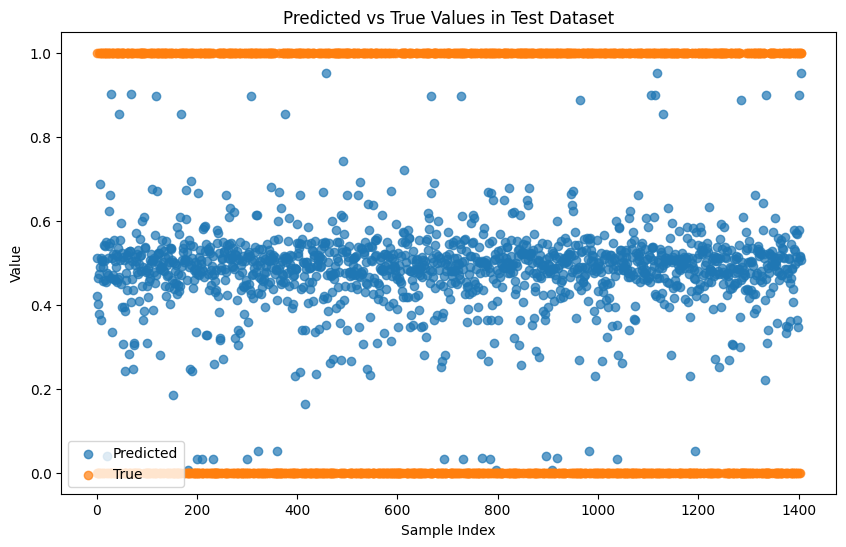

In [105]:
import matplotlib.pyplot as plt

# Get the model predictions on the test dataset
model.eval()
with torch.no_grad():
    x, edge_index, edge_attr = test_data.x, test_data.edge_index, test_data.edge_attr
    edge_label_index, edge_label = test_data.edge_label_index, test_data.edge_label

    node_emb = model.gnn(x, edge_index, edge_attr)
    u_emb = node_emb[edge_label_index[0]]
    v_emb = node_emb[edge_label_index[1]]
    preds = model.link_predictor(u_emb, v_emb)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(preds)), preds.cpu().numpy(), label='Predicted', alpha=0.7)
plt.scatter(range(len(edge_label)), edge_label.cpu().numpy(), label='True', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predicted vs True Values in Test Dataset')
plt.legend()
plt.show()

# Evaluation

In [110]:
sweep_config = {
    'method': 'bayes',  # bayes, grid, or random
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'   
    },
    'parameters': {
        'hidden_dim': {
            'values': [32, 64, 128]
        },
        'num_conv_layers': {
            'values': [2, 3, 4]
        },
        'num_linear_layers': {
            'values': [1, 2, 3]
        },
        'lr': {
            'distribution': 'log_uniform',
            'min': 1e-4,
            'max': 1e-2
        },
        'weight_decay': {
            'distribution': 'log_uniform',
            'min': 1e-5,
            'max': 1e-2
        },
        'dropout': {
            'values': [0.0, 0.2, 0.4]
        }
    }
}

In [114]:
def train_sweep():
    with wandb.init() as run:
        config = wandb.config
        """
        model = LitGNN(
                input_dim=data.x.shape[1],
                conv_layers=config.num_conv_layers,
                link_predictor_layers=config.num_linear_layers,
                conv_hidden_dim=config.hidden_dim,
                link_hidden_dim=config.hidden_dim,
                learning_rate=config.lr,
                weight_decay=config.weight_decay,
                dropout_rate=config.dropout
            ) """
        model = LitGNN(input_dim=data.x.shape[1])

        trainer = pl.Trainer(
            max_epochs=50,
            logger=pl.loggers.WandbLogger(),
            callbacks=[
                pl.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                pl.callbacks.ModelCheckpoint(monitor='val_loss')
            ]
        )
        trainer.fit(model, train_loader, val_loader)
        trainer.test(model, test_loader)

In [115]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="nba_lineup_prediction")
# Start the sweep agent
wandb.agent(sweep_id, function=train_sweep, count=5)  # Run 5 agents in parallel

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. lr uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.
wandb: WARNING   Violation 2. weight_decay uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.


Create sweep with ID: vlnj32yu
Sweep URL: https://wandb.ai/rokaati18-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem/nba_lineup_prediction/sweeps/vlnj32yu


wandb: Agent Starting Run: gvs58ert with config:
wandb: 	dropout: 0.2
wandb: 	hidden_dim: 32
wandb: 	lr: 1.0012672756607033
wandb: 	num_conv_layers: 4
wandb: 	num_linear_layers: 3
wandb: 	weight_decay: 1.002390598864212


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.7640
Train Accuracy: 0.4384
Train AUC: 0.4020
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8ert, train_loss=0.764, train_acc=0.438, train_auc=0.402, val_loss=0.683, val_acc=0.544, val_auc=0.664]        Train Loss: 0.7016
Train Accuracy: 0.5184
Train AUC: 0.5299
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8ert, train_loss=0.702, train_acc=0.518, train_auc=0.530, val_loss=0.673, val_acc=0.588, val_auc=0.722]        Train Loss: 0.6971
Train Accuracy: 0.5424
Train AUC: 0.6136
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8ert, train_loss=0.697, train_acc=0.542, train_auc=0.614, val_loss=0.668, val_acc=0.597, val_auc=0.735]        Train Loss: 0.6828
Train Accuracy: 0.6168
Train AUC: 0.7031
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8ert, train_loss=0.683, train_acc=0.617, train_auc=0.703, val_loss=0.664, val_acc=0.628, val_auc=0.740]        Train Loss: 0.6702
Train Accuracy: 0.6128
Train AUC: 0.71

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s, v_num=8ert, train_loss=0.555, train_acc=0.726, train_auc=0.798, val_loss=0.536, val_acc=0.714, val_auc=0.812]


wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.11it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7133712768554688
        test_auc             0.803183376789093
        test_loss            0.542712390422821
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▁▃▃▄▇██████████████▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_auc,▁▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███████
val_loss,██▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁


wandb: Agent Starting Run: 29vsxzgs with config:
wandb: 	dropout: 0
wandb: 	hidden_dim: 128
wandb: 	lr: 1.0069905368863663
wandb: 	num_conv_layers: 3
wandb: 	num_linear_layers: 3
wandb: 	weight_decay: 1.0017362521182134


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.8716
Train Accuracy: 0.4432
Train AUC: 0.4156
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=xzgs, train_loss=0.872, train_acc=0.443, train_auc=0.416, val_loss=0.733, val_acc=0.439, val_auc=0.361]        Train Loss: 0.7728
Train Accuracy: 0.4576
Train AUC: 0.4378
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=xzgs, train_loss=0.773, train_acc=0.458, train_auc=0.438, val_loss=0.731, val_acc=0.500, val_auc=0.542]        Train Loss: 0.7203
Train Accuracy: 0.5392
Train AUC: 0.5274
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=xzgs, train_loss=0.720, train_acc=0.539, train_auc=0.527, val_loss=0.716, val_acc=0.514, val_auc=0.634]        Train Loss: 0.7026
Train Accuracy: 0.5944
Train AUC: 0.6082
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=xzgs, train_loss=0.703, train_acc=0.594, train_auc=0.608, val_loss=0.692, val_acc=0.628, val_auc=0.715]        Train Loss: 0.6960
Train Accuracy: 0.6288
Train AUC: 0.65

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=xzgs, train_loss=0.563, train_acc=0.724, train_auc=0.791, val_loss=0.523, val_acc=0.726, val_auc=0.818]


wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7140824794769287
        test_auc            0.8106640577316284
        test_loss           0.5292726159095764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▂▃▅██████████████████████████▇▇▇▇▇▇▇▇▇▇
val_auc,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
val_loss,██▇▇▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁


wandb: Agent Starting Run: mtxkct6f with config:
wandb: 	dropout: 0
wandb: 	hidden_dim: 64
wandb: 	lr: 1.0008077174098855
wandb: 	num_conv_layers: 4
wandb: 	num_linear_layers: 3
wandb: 	weight_decay: 1.0006864712882424


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.7224
Train Accuracy: 0.5224
Train AUC: 0.5322
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=ct6f, train_loss=0.722, train_acc=0.522, train_auc=0.532, val_loss=0.674, val_acc=0.752, val_auc=0.743]        Train Loss: 0.6956
Train Accuracy: 0.6000
Train AUC: 0.6114
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=ct6f, train_loss=0.696, train_acc=0.600, train_auc=0.611, val_loss=0.666, val_acc=0.756, val_auc=0.745]        Train Loss: 0.6862
Train Accuracy: 0.6600
Train AUC: 0.6537
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=ct6f, train_loss=0.686, train_acc=0.660, train_auc=0.654, val_loss=0.659, val_acc=0.753, val_auc=0.745]        Train Loss: 0.7043
Train Accuracy: 0.6992
Train AUC: 0.7034
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=ct6f, train_loss=0.704, train_acc=0.699, train_auc=0.703, val_loss=0.656, val_acc=0.754, val_auc=0.748]        Train Loss: 0.6772
Train Accuracy: 0.7208
Train AUC: 0.72

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s, v_num=ct6f, train_loss=0.540, train_acc=0.735, train_auc=0.809, val_loss=0.505, val_acc=0.746, val_auc=0.839]

wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7311521768569946
        test_auc            0.8296064734458923
        test_loss           0.5097132921218872
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▆█▇▇▂▁▂▄▆▅▅▆▅▅▅▅▄▄▃▃▄▅▃▄▅▄▃▂▂▂▄▄▅▅▅▅▄▃▁▄
val_auc,▂▂▂▂▂▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,██▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁


wandb: Agent Starting Run: 9v5ysxqp with config:
wandb: 	dropout: 0
wandb: 	hidden_dim: 64
wandb: 	lr: 1.0088366135113855
wandb: 	num_conv_layers: 2
wandb: 	num_linear_layers: 1
wandb: 	weight_decay: 1.0035090792074977


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.7736
Train Accuracy: 0.5312
Train AUC: 0.5480
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=sxqp, train_loss=0.774, train_acc=0.531, train_auc=0.548, val_loss=0.669, val_acc=0.676, val_auc=0.734]        Train Loss: 0.7433
Train Accuracy: 0.6064
Train AUC: 0.6065
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=sxqp, train_loss=0.743, train_acc=0.606, train_auc=0.607, val_loss=0.672, val_acc=0.666, val_auc=0.730]        Train Loss: 0.7223
Train Accuracy: 0.6376
Train AUC: 0.6528
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=sxqp, train_loss=0.722, train_acc=0.638, train_auc=0.653, val_loss=0.676, val_acc=0.656, val_auc=0.727]        Train Loss: 0.6813
Train Accuracy: 0.6456
Train AUC: 0.6947
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=sxqp, train_loss=0.681, train_acc=0.646, train_auc=0.695, val_loss=0.670, val_acc=0.667, val_auc=0.733]        Train Loss: 0.6958
Train Accuracy: 0.6584
Train AUC: 0.67

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s, v_num=sxqp, train_loss=0.578, train_acc=0.729, train_auc=0.794, val_loss=0.556, val_acc=0.738, val_auc=0.821]

wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.72901850938797
        test_auc             0.813040554523468
        test_loss           0.5577583909034729
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▃▂▁▃▄▄▄▃▂▂▂▂▂▄▆▇▇▇▇██████▇▇▇▇▇▇██▇▇▇▇▇▇▇
val_auc,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇████
val_loss,████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▁


wandb: Agent Starting Run: vso5vjne with config:
wandb: 	dropout: 0
wandb: 	hidden_dim: 128
wandb: 	lr: 1.0055782236327275
wandb: 	num_conv_layers: 4
wandb: 	num_linear_layers: 3
wandb: 	weight_decay: 1.0012336137266666


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.4 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | tr

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train Loss: 0.9042
Train Accuracy: 0.4400
Train AUC: 0.4297
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=vjne, train_loss=0.904, train_acc=0.440, train_auc=0.430, val_loss=0.723, val_acc=0.322, val_auc=0.285]        Train Loss: 0.7765
Train Accuracy: 0.4640
Train AUC: 0.4943
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=vjne, train_loss=0.777, train_acc=0.464, train_auc=0.494, val_loss=0.714, val_acc=0.494, val_auc=0.429]        Train Loss: 0.7623
Train Accuracy: 0.4904
Train AUC: 0.4967
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=vjne, train_loss=0.762, train_acc=0.490, train_auc=0.497, val_loss=0.695, val_acc=0.518, val_auc=0.620]        Train Loss: 0.7171
Train Accuracy: 0.5520
Train AUC: 0.5741
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=vjne, train_loss=0.717, train_acc=0.552, train_auc=0.574, val_loss=0.681, val_acc=0.601, val_auc=0.701]        Train Loss: 0.7390
Train Accuracy: 0.5768
Train AUC: 0.59

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s, v_num=vjne, train_loss=0.573, train_acc=0.706, train_auc=0.786, val_loss=0.550, val_acc=0.734, val_auc=0.824]


wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7325747013092041
        test_auc            0.8178149461746216
        test_loss           0.5520617365837097
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_acc,▁
test_auc,▁
test_loss,▁
train_acc,▁
train_auc,▁
train_loss,▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▄▄▆▇███████████████████████████████████
val_auc,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,██▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
